# Machine Learning Isaac

In [1]:
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from fastcore.basics import Path, AttrDict
import utils_isaac as utils
import numpy as np
import pickle
from datetime import datetime

# This is used to import the evaluation script, not needed for training
import sys
sys.path.append('../') 
import evaluation


In [2]:
config = AttrDict(
    challenge_data_dir = Path('../../dataset/'),
    valid_ratio = 0.1,
    lag_steps = 6,
    tolerance= 6, # Default evaluation tolerance
)

In [3]:
# Define the list of feature columns
feature_cols = [
    "Eccentricity",
    "Semimajor Axis (m)",
    "Inclination (deg)",
    "RAAN (deg)",
    "Argument of Periapsis (deg)",
    "True Anomaly (deg)",
    "Latitude (deg)",
    "Longitude (deg)",
    "Altitude (m)",
    "X (m)",
    "Y (m)",
    "Z (m)",
    "Vx (m/s)",
    "Vy (m/s)",
    "Vz (m/s)"
]

In [4]:
# Define the directory paths
train_data_dir = config.challenge_data_dir / "train"

# Load the ground truth data
ground_truth = pd.read_csv(config.challenge_data_dir / 'train_labels.csv')

# Apply the function to the ground truth data
data, updated_feature_cols = utils.tabularize_data(train_data_dir,
                                                   feature_cols, 
                                                   ground_truth,
                                                   lag_steps=config.lag_steps,
                                                   fill_na=False)

# # For each ObjectID, show the first rows of the columns TimeIndex, ObjectID, EW, and NS
# data[['ObjectID', 'TimeIndex' , 'EW', 'NS']].groupby('ObjectID').head(2).head(10)

In [10]:
data['EW'] = data['EW'].fillna('Nothing')
data['NS'] = data['NS'].fillna('Nothing')

In [15]:
data.to_pickle('Data_With_Nothing.pkl')

In [22]:
from catboost import CatBoostRegressor, CatBoostClassifier

In [16]:
starttime = datetime.fromisoformat("2023-01-01 00:00:00+00:00")
endtime = datetime.fromisoformat("2023-07-01 00:00:00+00:00")

In [17]:
def data_to_add(data_df,ground_truth_object):
    ground_truth_object.Type = ground_truth_object.Type.fillna('NK')
    ground_truth_EW = ground_truth_object[ground_truth_object['Direction'] == 'EW'].copy()
    ground_truth_NS = ground_truth_object[ground_truth_object['Direction'] == 'NS'].copy()

    # Create 'EW' and 'NS' labels and fill 'unknown' values
    ground_truth_EW['EW_baseline_heuristic'] = ground_truth_EW['Node'] + \
        '-' + ground_truth_EW['Type']
    ground_truth_NS['NS_baseline_heuristic'] = ground_truth_NS['Node'] + \
        '-' + ground_truth_NS['Type']
    ground_truth_EW.drop(
        ['Node', 'Type', 'Direction'], axis=1, inplace=True)
    ground_truth_NS.drop(
        ['Node', 'Type', 'Direction'], axis=1, inplace=True)
    merged_df = pd.merge(data_df,
                             ground_truth_EW.sort_values('TimeIndex'),
                             on=['TimeIndex', 'ObjectID'],
                         how='left')
    merged_df = pd.merge_ordered(merged_df,
                                 ground_truth_NS.sort_values(
                                     'TimeIndex'),
                                 on=['TimeIndex', 'ObjectID'],
                                 how='left')

    # Fill 'unknown' values in 'EW' and 'NS' columns that come before the first valid observation
    merged_df['EW_baseline_heuristic'].ffill(inplace=True)
    merged_df['NS_baseline_heuristic'].ffill(inplace=True)
    return merged_df

In [18]:
def add_baseline_heuristic(data,objectId,starttime,endtime):
    detected, ssEW, lon_std = utils.detect_ew_pol_nodes(data.loc[data.ObjectID==objectId][feature_cols],objectId,starttime,endtime)
    nodes, filtered = utils.filter_and_merge_nodes(data.loc[data.ObjectID==objectId][feature_cols], detected, ssEW, lon_std,   objectId, starttime, endtime, 12)
    nodes = utils.detect_sn_pol_nodes(data, nodes, filtered, objectId, starttime, 12)
    merged_df = data_to_add(data.loc[data.ObjectID==objectId],utils.data_post_processing(nodes,starttime))
    return merged_df

In [19]:
from tqdm import tqdm

In [ ]:
# all_data = []
# for objectId in tqdm(data.ObjectID.unique()):
#     try:
#         all_data.append(add_baseline_heuristic(data,objectId,starttime,endtime))
#     except:
#         print(objectId)

In [ ]:
#data = pd.concat(all_data,axis=0)

In [ ]:
data = pd.read_pickle('Test_To_Keep.pkl')
data = pd.concat([data,pd.get_dummies(data[['EW_baseline_heuristic']]),pd.get_dummies(data[['NS_baseline_heuristic']])],axis=1)

In [ ]:
updated_feature_cols = list(data.columns[1:])
updated_feature_cols.remove('EW')
updated_feature_cols.remove('NS')
updated_feature_cols.remove('EW_baseline_heuristic')
updated_feature_cols.remove('NS_baseline_heuristic')

In [20]:
# Create a validation set without mixing the ObjectIDs
object_ids = data['ObjectID'].unique()
train_ids, valid_ids = train_test_split(object_ids, 
                                        test_size=config.valid_ratio, 
                                        random_state=43)

train_data = data[data['ObjectID'].isin(train_ids)].copy()
valid_data = data[data['ObjectID'].isin(valid_ids)].copy()

ground_truth_train = ground_truth[ground_truth['ObjectID'].isin(train_ids)].copy()
ground_truth_valid = ground_truth[ground_truth['ObjectID'].isin(valid_ids)].copy()

# Count the number of objects in the training and validation sets
print('Number of objects in the training set:', len(train_data['ObjectID'].unique()))
print('Number of objects in the validation set:', len(valid_data['ObjectID'].unique()))

Number of objects in the training set: 1710
Number of objects in the validation set: 190


Next we will make sure that there every label, both in the direction EW and NS,
is present both in the training and validation partitions

In [21]:
# Get the unique values of EW and NS in train and test data
train_EW = set(train_data['EW'].unique())
train_NS = set(train_data['NS'].unique())
valid_EW = set(valid_data['EW'].unique())
valid_NS = set(valid_data['NS'].unique())

# Get the values of EW and NS that are in test data but not in train data
missing_EW = valid_EW.difference(train_EW)
missing_NS = valid_NS.difference(train_NS)

# Check if all the values in EW are also present in NS
if not set(train_data['EW'].unique()).issubset(set(train_data['NS'].unique())):
    # Get the values of EW that are not present in NS
    missing_EW_NS = set(train_data['EW'].unique()).difference(
        set(train_data['NS'].unique())
    )
else:
    missing_EW_NS = None

# Print the missing values of EW and NS
print("Missing values of EW in test data:", missing_EW)
print("Missing values of NS in test data:", missing_NS)
print("Values of EW not present in NS:", missing_EW_NS)

Missing values of EW in test data: set()
Missing values of NS in test data: set()
Values of EW not present in NS: {'AD-NK'}


In [ ]:
import xgboost as xgb

In [23]:
# Convert categorical data to numerical data
le_EW = LabelEncoder()
le_NS = LabelEncoder()

# Encode the 'EW' and 'NS' columns
train_data['EW_encoded'] = le_EW.fit_transform(train_data['EW'])
train_data['NS_encoded'] = le_NS.fit_transform(train_data['NS'])

In [ ]:
# train_data['EW_baseline_heuristic_encoded'] = le_EW.transform(train_data['EW_baseline_heuristic'])
# train_data['NS_baseline_heuristic_encoded'] = le_NS.transform(train_data['NS_baseline_heuristic'])

In [ ]:
# valid_data['EW_baseline_heuristic_encoded'] = le_EW.transform(valid_data['EW_baseline_heuristic'])
# valid_data['NS_baseline_heuristic_encoded'] = le_NS.transform(valid_data['NS_baseline_heuristic'])

In [24]:
# Define the Random Forest model for EW
model_EW = CatBoostClassifier(n_estimators=100, random_state=42)
# Fit the model to the training data for EW
model_EW.fit(train_data[updated_feature_cols], train_data['EW_encoded'])

# Define the Random Forest model for NS
model_NS = CatBoostClassifier(n_estimators=100, random_state=42)
# Fit the model to the training data for NS
model_NS.fit(train_data[updated_feature_cols], train_data['NS_encoded'])

Learning rate set to 0.5
0:	learn: 0.0651712	total: 20.1s	remaining: 33m 12s
1:	learn: 0.0410099	total: 34.9s	remaining: 28m 31s
2:	learn: 0.0356466	total: 47.8s	remaining: 25m 44s
3:	learn: 0.0294492	total: 1m	remaining: 24m 11s
4:	learn: 0.0228738	total: 1m 13s	remaining: 23m 11s
5:	learn: 0.0193620	total: 1m 25s	remaining: 22m 27s
6:	learn: 0.0167208	total: 1m 38s	remaining: 21m 47s
7:	learn: 0.0153653	total: 1m 51s	remaining: 21m 18s
8:	learn: 0.0218055	total: 2m 4s	remaining: 20m 54s
9:	learn: 0.0190697	total: 2m 17s	remaining: 20m 39s
10:	learn: 0.0160253	total: 2m 30s	remaining: 20m 17s
11:	learn: 0.0106443	total: 2m 43s	remaining: 19m 56s
12:	learn: 0.0096778	total: 2m 55s	remaining: 19m 36s
13:	learn: 0.0107099	total: 3m 8s	remaining: 19m 17s
14:	learn: 0.0089927	total: 3m 21s	remaining: 19m
15:	learn: 0.0094434	total: 3m 34s	remaining: 18m 44s
16:	learn: 0.0085799	total: 3m 47s	remaining: 18m 29s
17:	learn: 0.0109381	total: 4m	remaining: 18m 17s
18:	learn: 0.0114403	total: 4m

In [25]:
# Make predictions on the training data for EW
train_data['Predicted_EW'] = le_EW.inverse_transform(
    model_EW.predict(train_data[updated_feature_cols])
)

# Make predictions on the validation data for NS
train_data['Predicted_NS'] = le_NS.inverse_transform(
    model_NS.predict(train_data[updated_feature_cols])
)

# Print the first few rows of the test data with predictions for both EW and NS
train_data[['TimeIndex', 'ObjectID', 'EW', 
            'Predicted_EW', 'NS', 'Predicted_NS']].groupby('ObjectID').head(3)

C:\Appli\main_env\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Appli\main_env\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,TimeIndex,ObjectID,EW,Predicted_EW,NS,Predicted_NS
0,0,1,SS-HK,SS-EK,SS-HK,SS-HK
1,1,1,Nothing,Nothing,Nothing,Nothing
2,2,1,Nothing,Nothing,Nothing,Nothing
0,0,10,SS-CK,SS-CK,SS-NK,SS-NK
1,1,10,Nothing,Nothing,Nothing,Nothing
...,...,...,...,...,...,...
1,1,997,Nothing,Nothing,Nothing,Nothing
2,2,997,Nothing,Nothing,Nothing,Nothing
0,0,998,SS-NK,SS-NK,SS-NK,SS-NK
1,1,998,Nothing,Nothing,Nothing,Nothing


In [26]:
if config.valid_ratio > 0:
    # Make predictions on the validation data for EW
    valid_data['Predicted_EW'] = le_EW.inverse_transform(
        model_EW.predict(valid_data[updated_feature_cols])
    )

    # Make predictions on the validation data for NS
    valid_data['Predicted_NS'] = le_NS.inverse_transform(
        model_NS.predict(valid_data[updated_feature_cols])
    )

C:\Appli\main_env\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Appli\main_env\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The `NodeDetectionEvaluator` class in the evaluation module allows not only to
compute the general score for a given dataset, but get evaluations per object, and
even plots that show how the predictions look like in a timeline

In [33]:
train_data['Predicted_EW'] = train_data['Predicted_EW'].mask(train_data['Predicted_EW']=='Nothing').ffill()
train_data['Predicted_NS'] = train_data['Predicted_NS'].mask(train_data['Predicted_NS']=='Nothing').ffill()

In [34]:
train_results = utils.convert_classifier_output(train_data)
evaluator = evaluation.NodeDetectionEvaluator(ground_truth_train, train_results, 
                                              tolerance=config.tolerance)
precision, recall, f2, rmse = evaluator.score()
print(f'Precision for the train set: {precision:.2f}')
print(f'Recall for the train set: {recall:.2f}')
print(f'F2 for the train set: {f2:.2f}')
print(f'RMSE for the train set: {rmse:.2f}')

C:\Users\isaac\Documents\Challenge_Francois\splid-devkit\baseline_submissions\isaac_ml\utils_isaac.py:103: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  keep = groups[['Node', 'Type']].apply(


Precision for the train set: 0.76
Recall for the train set: 0.51
F2 for the train set: 0.55
RMSE for the train set: 0.24


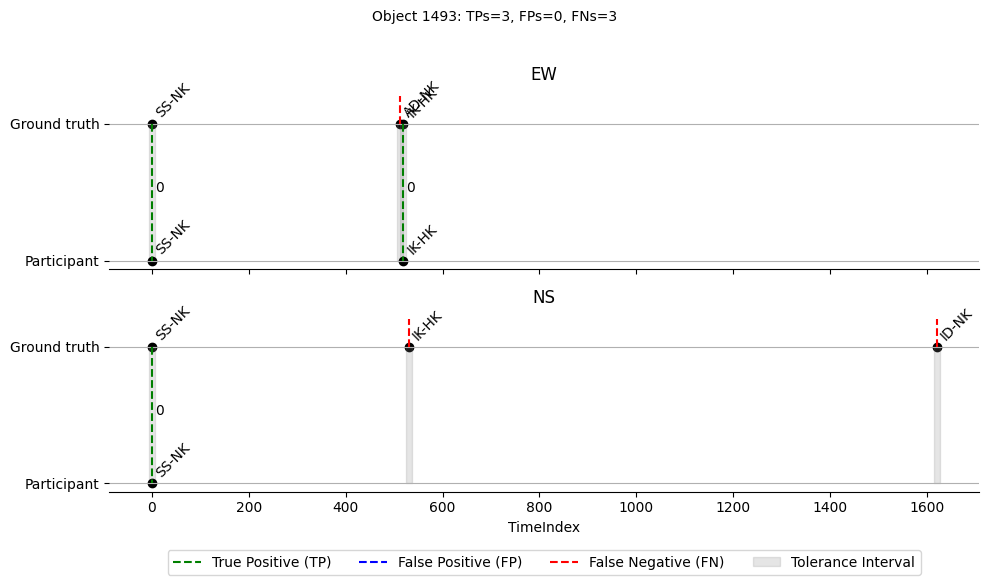

In [35]:
# Plot the evaluation timeline for a random ObjectID from the training set
evaluator.plot(np.random.choice(train_data['ObjectID'].unique()))

In [36]:
# Loop over the Object IDs in the training set and call the evaluation
# function for each object and aggregate the results
total_tp = 0
total_fp = 0
total_fn = 0
for oid in train_data['ObjectID'].unique():
    tp, fp, fn, gt_object, p_object = evaluator.evaluate(oid)
    total_tp += tp
    total_fp += fp
    total_fn += fn

print(f'Total true positives: {total_tp}')
print(f'Total false positives: {total_fp}')
print(f'Total false negatives: {total_fn}')

Total true positives: 3676
Total false positives: 1131
Total false negatives: 3464


In [37]:
valid_data['Predicted_EW'] = valid_data['Predicted_EW'].mask(valid_data['Predicted_EW']=='Nothing').ffill()
valid_data['Predicted_NS'] = valid_data['Predicted_NS'].mask(valid_data['Predicted_NS']=='Nothing').ffill()

In [38]:
if config.valid_ratio > 0:
    valid_results = utils.convert_classifier_output(valid_data)
    evaluator = evaluation.NodeDetectionEvaluator(ground_truth_valid, 
                                                  valid_results,
                                                  tolerance=config.tolerance)
precision, recall, f2, rmse = evaluator.score()
print(f'Precision for the validation set: {precision:.2f}')
print(f'Recall for the validation set: {recall:.2f}')
print(f'F2 for the validation set: {f2:.2f}')
print(f'RMSE for the validation set: {rmse:.2f}')

C:\Users\isaac\Documents\Challenge_Francois\splid-devkit\baseline_submissions\isaac_ml\utils_isaac.py:103: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  keep = groups[['Node', 'Type']].apply(


Precision for the validation set: 0.79
Recall for the validation set: 0.50
F2 for the validation set: 0.54
RMSE for the validation set: 0.30


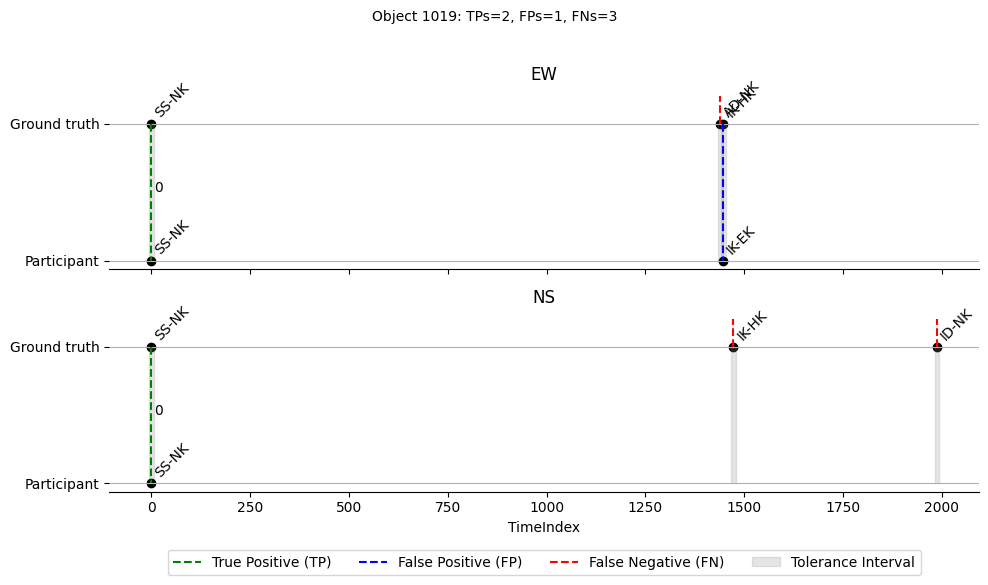

In [39]:
# Plot the evaluation timeline for a random ObjectID from the training set
evaluator.plot(np.random.choice(valid_data['ObjectID'].unique()))


In [ ]:
# Save the trained random forest models (and label encoders) to disk
# Create the folder trained_model if it doesn't exist
Path('trained_model').mkdir(exist_ok=True)
pickle.dump(model_EW, open('trained_model/model_EW.pkl', 'wb'))
pickle.dump(model_NS, open('trained_model/model_NS.pkl', 'wb'))
pickle.dump(le_EW, open('trained_model/le_EW.pkl', 'wb'))
pickle.dump(le_NS, open('trained_model/le_NS.pkl', 'wb'))